In [1]:
import nltk
from nltk.corpus import gutenberg
from string import punctuation

nltk.download("gutenberg")
nltk.download('punkt')
bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'


[nltk_data] Downloading package gutenberg to /home/weiteh/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /home/weiteh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# lower case all words and filter the punctuation and numbers
norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]

In [3]:
norm_bible = [ " ".join(x) for x in norm_bible]

In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

wpt = nltk.WordPunctTokenizer()
nltk.download("stopwords")

stop_words = nltk.corpus.stopwords.words('english')
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

[nltk_data] Downloading package stopwords to /home/weiteh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
norm_bible = filter(None, normalize_corpus(norm_bible))

In [6]:
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

In [7]:
print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


![title](img/word2vec-cbow.png)

In [8]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()

Using TensorFlow backend.
/home/weiteh/word2vec/venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/weiteh/word2vec/venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/weiteh/word2vec/venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/weiteh/word2vec/venv/lib/python3.5/sit

In [9]:
tokenizer.fit_on_texts(norm_bible)

In [10]:
word2id = tokenizer.word_index

In [11]:
word2id['PAD'] = 0

In [12]:
id2word = tokenizer.index_word

In [13]:
id2word[0] = 'PAD'

In [14]:
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

In [15]:
vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('sinite', 6780), ('munitions', 10827), ('tempt', 2691), ('zelophehad', 3143), ('zadok', 1037), ('ascribe', 5999), ('window', 2453), ('worketh', 1428), ('rolled', 2953), ('anakims', 3516)]


In [16]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            # vocab_size + 1 to avoid exception when to_categorical returns the last index (12424)
            # 0 is a reserved index
            y = np_utils.to_categorical(label_word, vocab_size) 
            
            yield (x, y)
                

In [17]:
# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
        if i == 10:
            break
        i += 1

Context (X): ['old', 'testament', 'james', 'bible'] -> Target (Y): king
Context (X): ['first', 'book', 'called', 'genesis'] -> Target (Y): moses
Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light


In [18]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

In [19]:
# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [20]:
# view model summary
print(cbow.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            1242500   
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12425)             1254925   
Total params: 2,497,425
Trainable params: 2,497,425
Non-trainable params: 0
_________________________________________________________________
None


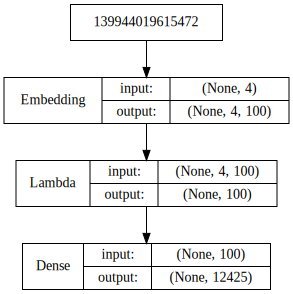

In [21]:
# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [22]:
for epoch in range(1, 20):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))
            print('Epoch:', epoch, '\tLoss:', loss)
    print()

Processed 100000 (context, word) pairs
Epoch: 1 	Loss: 848516.8165124105
Processed 200000 (context, word) pairs
Epoch: 1 	Loss: 1904098.162887712
Processed 300000 (context, word) pairs
Epoch: 1 	Loss: 3082571.9013154404

Processed 100000 (context, word) pairs
Epoch: 2 	Loss: 1047760.6006003421
Processed 200000 (context, word) pairs
Epoch: 2 	Loss: 2201740.7181942514
Processed 300000 (context, word) pairs
Epoch: 2 	Loss: 3351353.3083837815

Processed 100000 (context, word) pairs
Epoch: 3 	Loss: 1054670.6652652072
Processed 200000 (context, word) pairs
Epoch: 3 	Loss: 2206707.5963705657
Processed 300000 (context, word) pairs
Epoch: 3 	Loss: 3347636.6375550968

Processed 100000 (context, word) pairs
Epoch: 4 	Loss: 1043625.9000906495
Processed 200000 (context, word) pairs
Epoch: 4 	Loss: 2185883.75619327
Processed 300000 (context, word) pairs
Epoch: 4 	Loss: 3330653.64733051

Processed 100000 (context, word) pairs
Epoch: 5 	Loss: 1065997.9725992712
Processed 200000 (context, word) pairs
E

In [23]:
weights = cbow.get_weights()[0]

In [24]:
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

(12424, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
shall,-0.252762,0.875928,1.333759,1.317303,0.726024,-4.161635,0.042620,0.072045,0.036135,1.271854,...,-0.049555,-0.698928,2.006484,1.787941,-0.507635,-0.771421,-0.857663,0.847739,-0.239112,0.466033
unto,-1.000185,-0.443811,-0.853266,2.256062,-2.822240,-1.663752,3.925170,1.050252,1.687156,2.633649,...,1.775536,-1.998470,-0.504991,0.363600,0.231358,-2.256495,-1.003457,-0.209728,0.340843,-1.187086
lord,1.190516,-1.641793,-0.670725,1.248516,-1.818018,-2.642782,0.516240,-0.181705,1.149439,0.897360,...,-0.229912,-2.757271,0.919006,-0.429050,0.111108,-0.480288,-0.485003,-0.069682,0.696978,0.167227
thou,-0.898649,0.477333,-1.633646,0.902412,-0.245227,-0.253196,-0.005445,-0.500010,-0.500856,1.635019,...,-0.526804,0.332105,-0.078667,-0.549390,0.153660,-0.396543,1.092445,-1.214475,0.153579,0.774406
thy,-0.397165,-0.121370,0.675113,-0.558662,1.576094,0.716682,-1.289818,-0.004304,-1.082852,-0.440885,...,-0.045840,1.268043,-0.298018,1.130146,-0.661818,-1.250847,1.355970,0.376677,-0.871604,-0.259294


In [25]:
from sklearn.metrics.pairwise import euclidean_distances

In [26]:
# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

(12424, 12424)


In [27]:
distance_matrix[word2id['shall'] - 1].argsort()[1:6]+1

array([ 7, 10, 46,  6, 39])

In [28]:
# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:10]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}


In [29]:
similar_words

{'egypt': ['thither',
  'led',
  'lot',
  'valley',
  'meet',
  'camp',
  'whither',
  'gilead',
  'north'],
 'famine': ['inherit',
  'yield',
  'continue',
  'strangers',
  'signs',
  'flood',
  'pestilence',
  'cease',
  'lived'],
 'god': ['good',
  'may',
  'glory',
  'let',
  'would',
  'cause',
  'time',
  'aaron',
  'judgment'],
 'gospel': ['remaineth',
  'vision',
  'tongues',
  'preached',
  'hearing',
  'scriptures',
  'preach',
  'queen',
  'resurrection'],
 'jesus': ['law',
  'dead',
  'world',
  'stood',
  'chief',
  'jews',
  'mother',
  'temple',
  'gate'],
 'john': ['wept',
  'howbeit',
  'remained',
  'laban',
  'sanctified',
  'officers',
  'peter',
  'dream',
  'abimelech'],
 'moses': ['pharaoh',
  'servants',
  'lo',
  'became',
  'wilderness',
  'angel',
  'received',
  'husband',
  'gate'],
 'noah': ['ninety',
  'shem',
  'barnabas',
  'fruitful',
  'plenteous',
  'joppa',
  'freely',
  'sixty',
  'soldiers']}